  0%|          | 0/25 [00:00<?, ?it/s]

Epoch[1/25], G Loss: -0.4549, D Loss: -0.3150


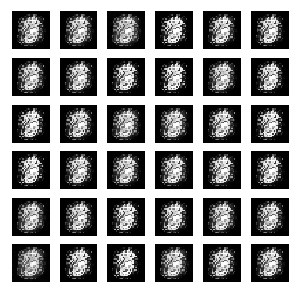

  4%|▍         | 1/25 [00:10<04:06, 10.26s/it]

Epoch[2/25], G Loss: -0.4234, D Loss: -0.4666


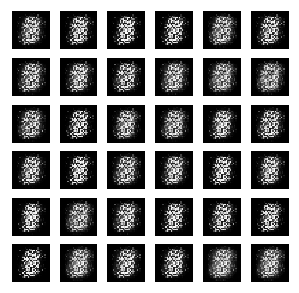

  8%|▊         | 2/25 [00:20<03:54, 10.21s/it]

Epoch[3/25], G Loss: -0.5202, D Loss: -0.3917


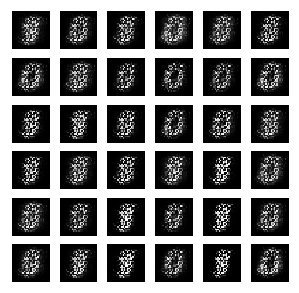

 12%|█▏        | 3/25 [00:30<03:46, 10.31s/it]

Epoch[4/25], G Loss: -0.6670, D Loss: -0.2773


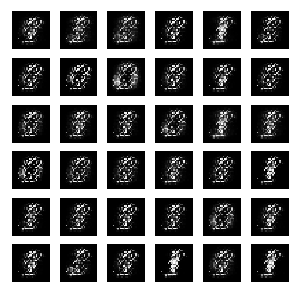

 16%|█▌        | 4/25 [00:41<03:37, 10.36s/it]

Epoch[5/25], G Loss: -0.6546, D Loss: -0.2797


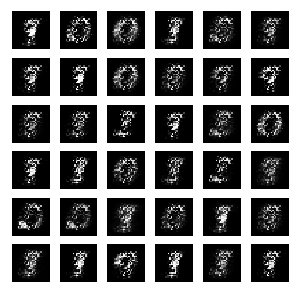

 20%|██        | 5/25 [00:51<03:27, 10.39s/it]

Epoch[6/25], G Loss: -0.5716, D Loss: -0.3561


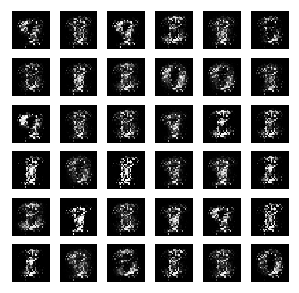

 24%|██▍       | 6/25 [01:02<03:17, 10.41s/it]

Epoch[7/25], G Loss: -0.4763, D Loss: -0.4186


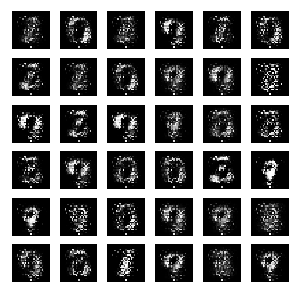

 28%|██▊       | 7/25 [01:13<03:08, 10.45s/it]

Epoch[8/25], G Loss: -0.4602, D Loss: -0.4440


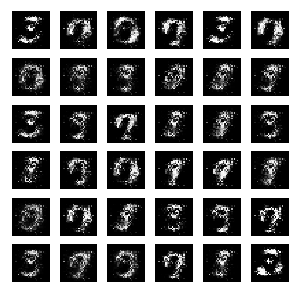

 32%|███▏      | 8/25 [01:23<02:58, 10.50s/it]

Epoch[9/25], G Loss: -0.4812, D Loss: -0.3870


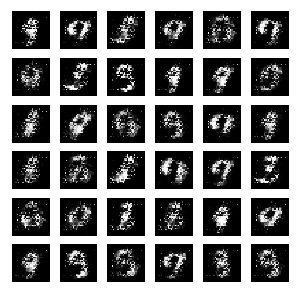

 36%|███▌      | 9/25 [01:34<02:48, 10.53s/it]

Epoch[10/25], G Loss: -0.4808, D Loss: -0.3753


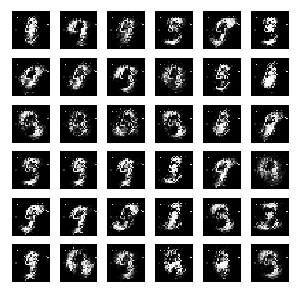

 40%|████      | 10/25 [01:46<02:39, 10.63s/it]

Epoch[11/25], G Loss: -0.4486, D Loss: -0.4359


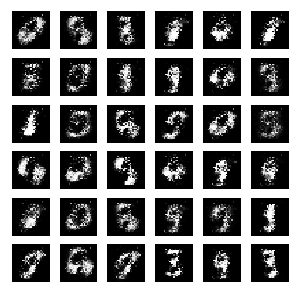

 44%|████▍     | 11/25 [01:58<02:30, 10.78s/it]

Epoch[12/25], G Loss: -0.5068, D Loss: -0.3512


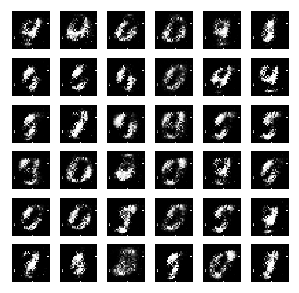

 48%|████▊     | 12/25 [02:12<02:24, 11.08s/it]

Epoch[13/25], G Loss: -0.4638, D Loss: -0.4196


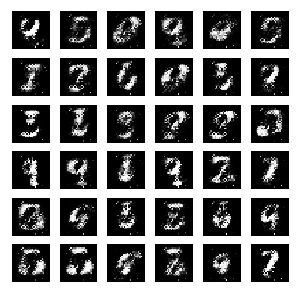

 52%|█████▏    | 13/25 [02:26<02:14, 11.23s/it]

Epoch[14/25], G Loss: -0.4403, D Loss: -0.4707


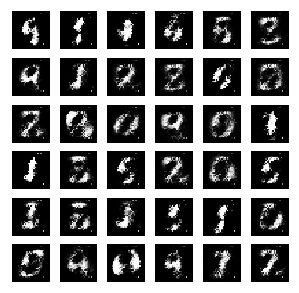

 56%|█████▌    | 14/25 [02:37<02:03, 11.23s/it]

Epoch[15/25], G Loss: -0.4617, D Loss: -0.4346


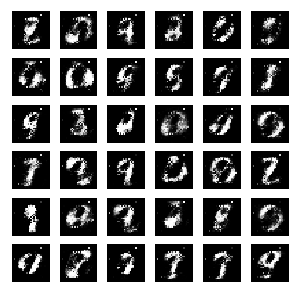

 60%|██████    | 15/25 [02:47<01:51, 11.17s/it]

Epoch[16/25], G Loss: -0.4613, D Loss: -0.4266


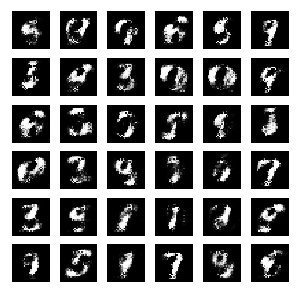

 64%|██████▍   | 16/25 [02:57<01:40, 11.11s/it]

In [ ]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))
from src.f_gan import *

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
# train_iter, val_iter, test_iter = get_data()

# Init model
model = fGAN(image_size=784,
             hidden_dim=400,
             z_dim=20)

# Init trainer
trainer = fGANTrainer(model=model,
                      train_iter=train_iter,
                      val_iter=val_iter,
                      test_iter=test_iter,
                      viz=True)

# Train
trainer.train(num_epochs=25,
              method='forward_kl',
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)

# Show loss
trainer.viz_loss()